In [2]:
from IPython.display import display
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_validate
from catboost import CatBoostClassifier

/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data = pd.read_csv("data/heart_prep.csv", sep=",")
print("Number of valid entries:", len(data))
data.describe()

Number of valid entries: 319795


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
count,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.00000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000,319795.000000
mean,0.085595,28.325399,0.412477,0.068097,0.037740,3.37171,3.898366,0.138870,0.475273,6.514536,4.396742,0.419972,0.775362,2.595028,7.097075,0.134061,0.036833,0.093244
std,0.279766,6.356100,0.492281,0.251912,0.190567,7.95085,7.955235,0.345812,0.499389,3.564759,1.212208,1.012487,0.417344,1.042918,1.436007,0.340718,0.188352,0.290775
min,0.000000,12.020000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,24.030000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,5.000000,0.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000
50%,0.000000,27.340000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,7.000000,5.000000,0.000000,1.000000,3.000000,7.000000,0.000000,0.000000,0.000000
75%,0.000000,31.420000,1.000000,0.000000,0.000000,2.00000,3.000000,0.000000,1.000000,9.000000,5.000000,0.000000,1.000000,3.000000,8.000000,0.000000,0.000000,0.000000
max,1.000000,94.850000,1.000000,1.000000,1.000000,30.00000,30.000000,1.000000,1.000000,12.000000,5.000000,3.000000,1.000000,4.000000,24.000000,1.000000,1.000000,1.000000


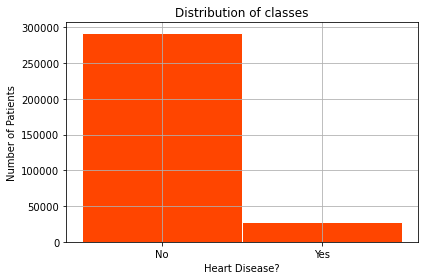

HeartDisease        27373
BMI                 27373
Smoking             27373
AlcoholDrinking     27373
Stroke              27373
PhysicalHealth      27373
MentalHealth        27373
DiffWalking         27373
Sex                 27373
AgeCategory         27373
Race                27373
Diabetic            27373
PhysicalActivity    27373
GenHealth           27373
SleepTime           27373
Asthma              27373
KidneyDisease       27373
SkinCancer          27373
dtype: int64

<Figure size 432x288 with 0 Axes>

In [4]:
data['HeartDisease'].hist(bins = 2, edgecolor='white', color='orangered')
plt.xticks(ticks=[0.25, 0.75], labels=['No', 'Yes'])
plt.title('Distribution of classes')
plt.xlabel('Heart Disease?')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.savefig('figures/distributions/distribution.png')
plt.show()
plt.clf()
data[data.HeartDisease == 1].count() 

In [5]:
#Preparation of target data Y, rest data X
data_target = data['HeartDisease']
data = data.drop(['HeartDisease'], axis=1)
#Generating Training and Test datasets in ratio 3:2
train, test, target_train, target_test = train_test_split(data, data_target, test_size=0.4, random_state=0)
print("Size Training dataset: ", len(train), "\nSize Test dataset: ", len(test)) #"\nSize Validation dataset", len(val))


Size Training dataset:  191877 
Size Test dataset:  127918


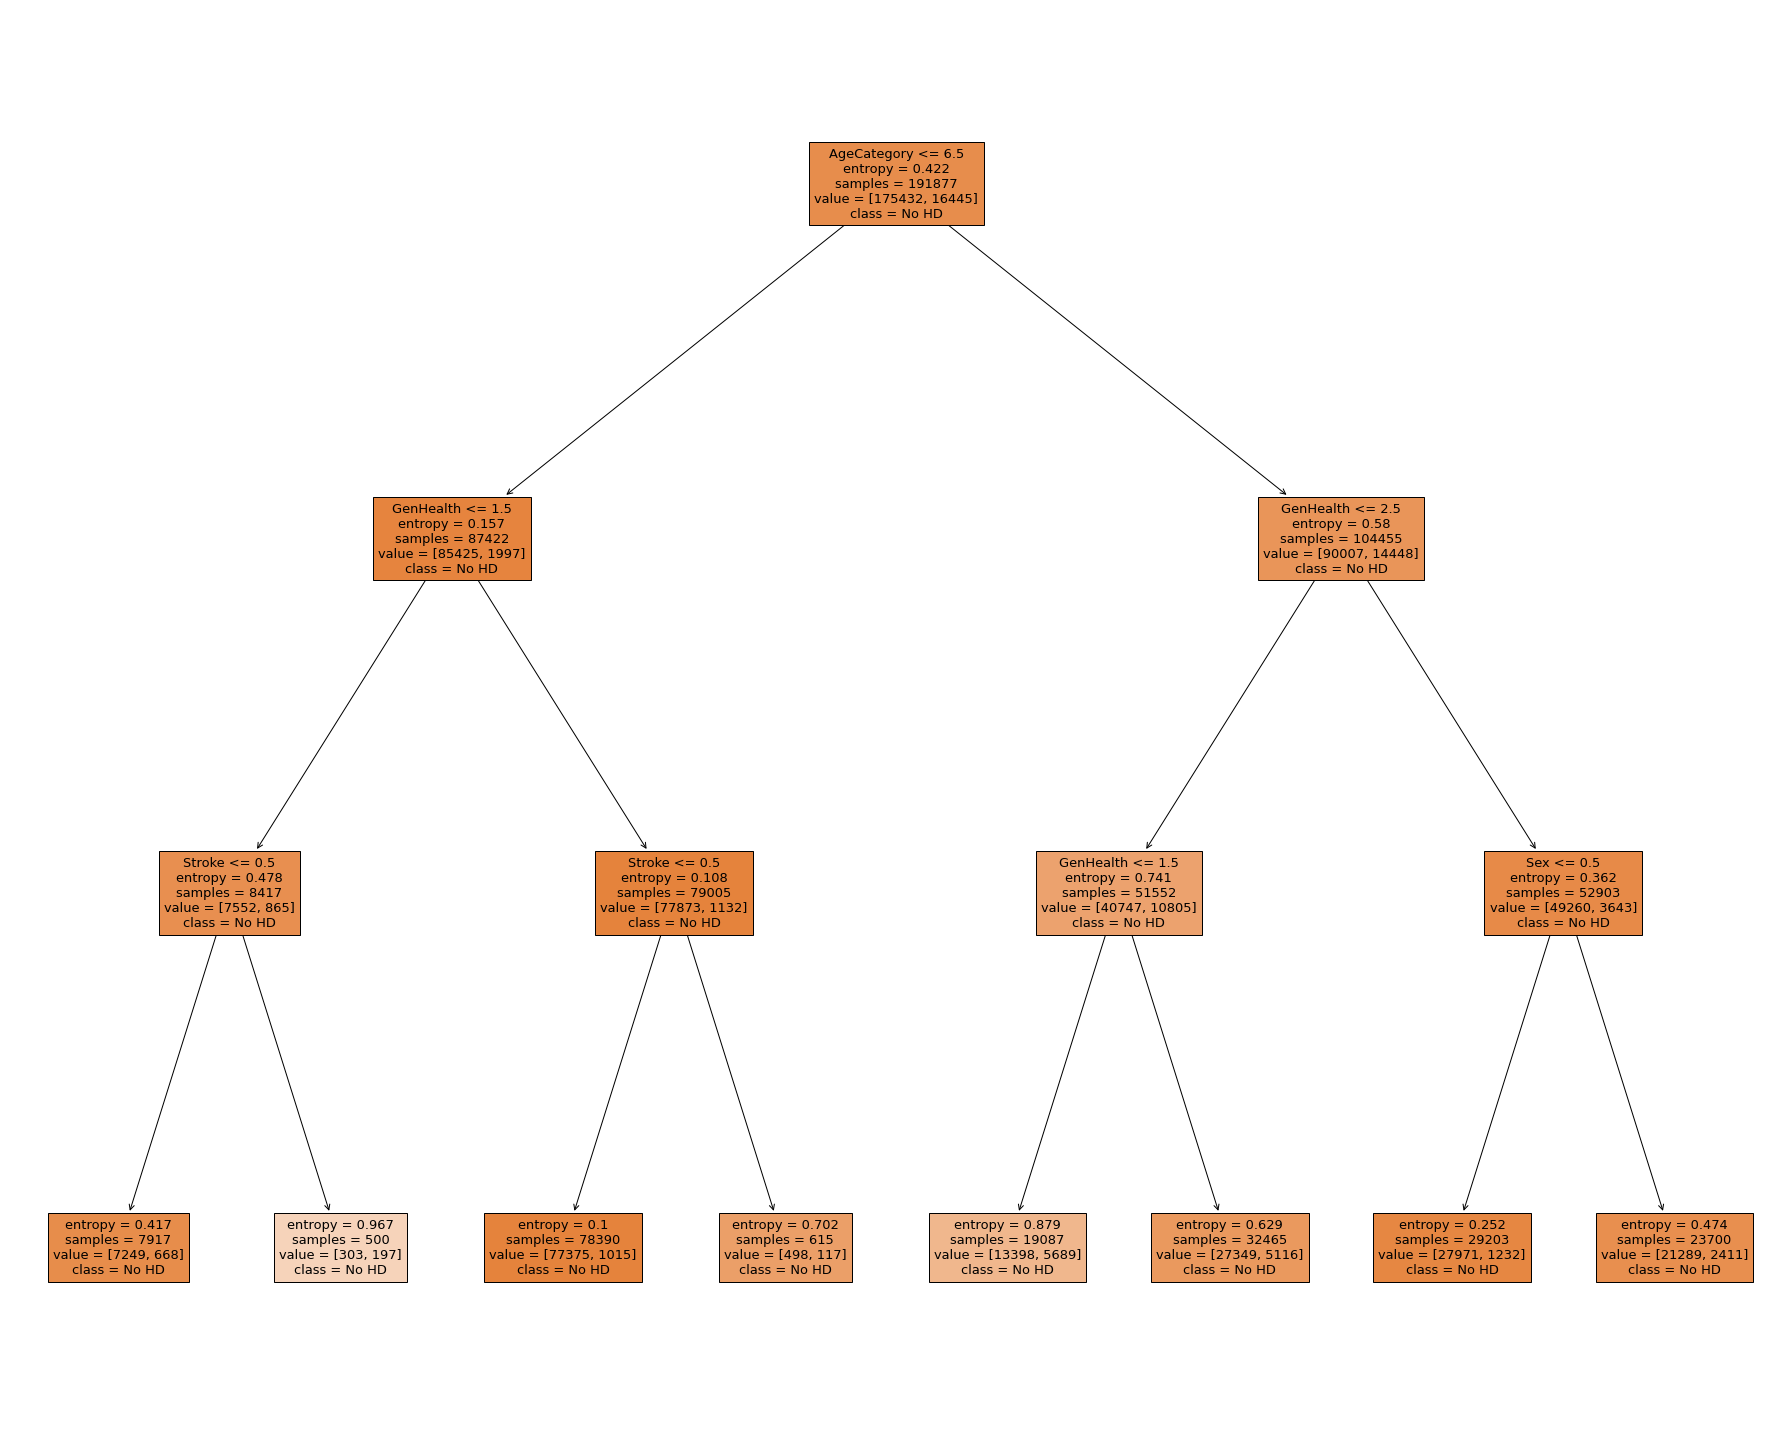

<Figure size 432x288 with 0 Axes>

In [6]:
dtc = DecisionTreeClassifier(max_depth=3, criterion='entropy')
dtc.fit(train, target_train)
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dtc, feature_names=data.columns,class_names=['No HD', 'HD'], filled=True)
plt.tight_layout()
plt.savefig("figures/decistion_tree.png")
plt.show()
plt.clf()

In [7]:
def training(algorithm, pred_train=False):
    algorithm.fit(train, target_train)
    prediction = algorithm.predict(test)
    prediction_proba = algorithm.predict_proba(test)
    if pred_train == False:
        return prediction, prediction_proba
    else:   
        prediction_train = algorithm.predict(train)
        prediction_proba_train = algorithm.predict_proba(train)
        return prediction, prediction_proba, prediction_train, prediction_proba_train


In [8]:
def comp_acc(prediction, truevalue):
    acc = accuracy_score(truevalue, prediction)
    return acc 

def comp_auc( prediction_proba, truevalue):
    auc = roc_auc_score(truevalue, prediction_proba[:, 1])
    return auc

def comp_roc( prediction_proba, truevalue):    
    fpr, tpr, thresholds = roc_curve(truevalue, prediction_proba[:, 1])
    #prec = precision_score(target_test, prediction)
    #rec = recall_score(target_test, prediction)
    #f1 = f1_score(target_test, prediction)
    return fpr, tpr, thresholds

In [9]:
def cross_val(algorithm, cv=5):
    scoring = {'acc': 'accuracy',
               'auc': 'roc_auc',
               'recall': 'recall'}

    results = cross_validate(algorithm, train, target_train, cv=cv, scoring=scoring, return_train_score=True)

    auc = results['test_auc']
    recall = results['test_recall']
    acc = results['test_acc']

    print(f'Area under RoC curve: {auc.mean():0.04f} ± {auc.std():0.04f}')
    print(f'Accuracy:             {acc.mean():0.04f} ± {acc.std():0.04f}')
    print(f'Recall:               {recall.mean():0.04f} ± {recall.std():0.04f}')
    return auc.mean(), auc.std(), acc.mean(), acc.std(), recall.mean(), recall.std()

In [10]:
def check_maxdepth(criterion='entropy', max_value=20, plot_figure=False):
    training_acc =[]
    training_auc =[]
    test_acc =[]
    test_auc =[]
    roc=[]
    test_rec=[]
    training_rec=[]
    for i in range(1, max_value):
        algo = DecisionTreeClassifier(max_depth=i, criterion=criterion, random_state=137)
        prediction, prediction_proba, prediction_train, prediction_proba_train = training(algo, True)
        training_acc.append(comp_acc(prediction_train, target_train))
        training_auc.append(comp_auc(prediction_proba_train, target_train))
        test_acc.append(comp_acc(prediction, target_test))
        test_auc.append(comp_auc(prediction_proba, target_test))
        test_rec.append(recall_score(target_test, prediction))
        training_rec.append(recall_score(target_train, prediction_train))
        roc.append(comp_roc(prediction_proba, target_test))
    if plot_figure==True:
        plt.figure()
        plt.plot(range(1, max_value), training_acc, '--', label='Acc. Training Set')
        plt.plot(range(1, max_value), test_acc, color='darkred', label='Acc. Test Set')
        plt.xlabel('Maximum Depth')
        plt.ylabel('Accuracy')
        plt.title('Accuracy DTC with ' + criterion)
        plt.legend()
        plt.tight_layout()
        plt.grid(alpha=0.4)
        path = 'figures/max_depth/max_depth_' + str(max_value) + '_Criterion_' + criterion + str('_acc.png')
        plt.savefig(path)
        plt.show()
        plt.clf()
        plt.figure()
        plt.plot(range(1, max_value), training_rec,'--', color='cornflowerblue', label='Rec. Training Set')
        plt.plot(range(1, max_value), test_rec, color='tomato', label='Rec. Test Set')
        plt.xlabel('Maximum Depth')
        plt.ylabel('Recall')
        plt.title('Recall DTC with ' + criterion)
        plt.legend()
        plt.tight_layout()
        plt.grid(alpha=0.4)
        path = 'figures/max_depth/max_depth_' + str(max_value) + '_Criterion_' + criterion + str('_rec.png')
        plt.savefig(path)
        plt.show()
        plt.clf()
        plt.figure()
        plt.plot(roc[0][0], roc[0][1], '--', label='ROC with ' + str(1) + ' Maximum Depth')  
        for i in range(1, int(max_value/4)):
            name= 'ROC with ' + str(i*4) + ' Maximum Depth'
            plt.plot(roc[(i-1)*4][0], roc[(i-1)*4][1], '--', label=name)  
        plt.legend()
        plt.xlabel('False Postive Rate')
        plt.ylabel('False Negative Rate')
        plt.title('ROC curves DTC with ' + criterion)
        plt.grid(alpha=0.4)
        plt.tight_layout()
        path = 'figures/max_depth/ROCmax_depth' + str(max_value) + '_Criterion' + criterion + str('.png')
        plt.savefig(path)  
        plt.show()

Checking max depth DTC with Entropy


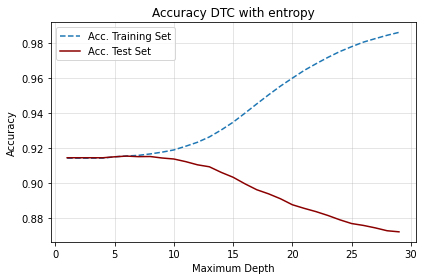

<Figure size 432x288 with 0 Axes>

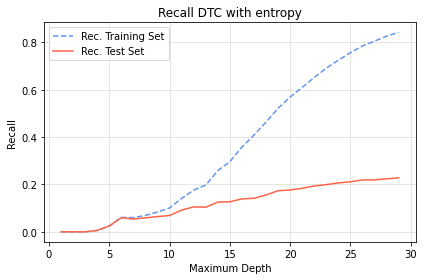

<Figure size 432x288 with 0 Axes>

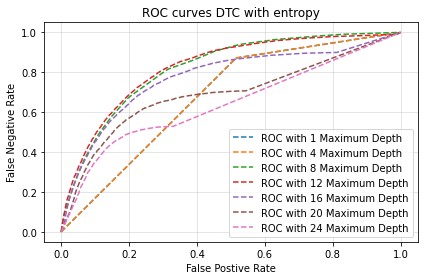

Checking max depth DTC with Gini


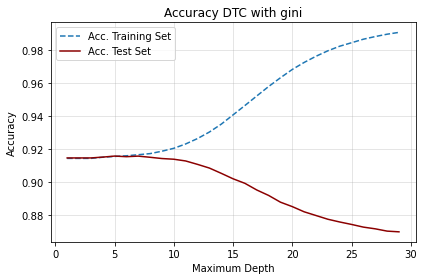

<Figure size 432x288 with 0 Axes>

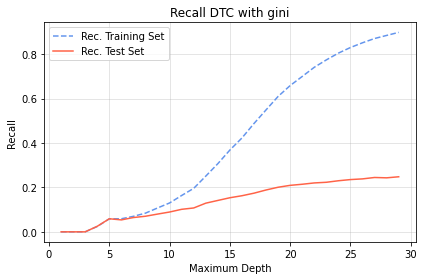

<Figure size 432x288 with 0 Axes>

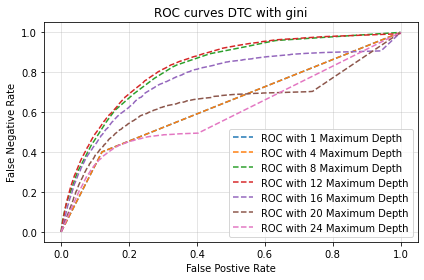

In [13]:
print('Checking max depth DTC with Entropy')
check_maxdepth('entropy', 30, True)
print('Checking max depth DTC with Gini')
check_maxdepth('gini', 30, True)

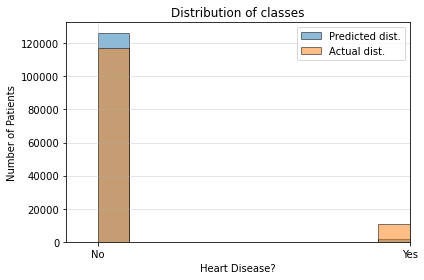

<Figure size 432x288 with 0 Axes>

In [11]:
dtc = DecisionTreeClassifier(max_depth=10, criterion='entropy', random_state=137)
pred, pred_proba = training(dtc)
plt.hist(pred, alpha=0.5, label='Predicted dist.', edgecolor='black')
plt.hist(target_test, alpha=0.5, label='Actual dist.', edgecolor='black')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.xlim(-0.1, 1)
plt.title('Distribution of classes')
plt.xlabel('Heart Disease?')
plt.ylabel('Number of Patients')
plt.legend()
plt.tight_layout()
plt.grid(alpha=0.4)
plt.savefig('figures/distributions/distribution_dtc.png')
plt.show()
plt.clf()

In [12]:
def plot_boosting_estimator(acc_test, acc_train, rec_test, rec_train, name):
    plt.figure()
    plt.plot(range(len(acc_test)), acc_test, color='red', linestyle='dotted', label='Acc. Test Set')
    plt.plot(range(len(acc_train)), acc_train, color='blue', linestyle='dotted', label='Acc. Train Set')
    plt.legend()
    plt.grid(alpha=0.4)
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
    plt.title('Accuracy of ' + name)
    plt.tight_layout()
    PATH='figures/boosting_est/acc' + name + '.png'
    plt.savefig(PATH)
    plt.show()
    plt.clf()
    
    plt.figure()
    plt.plot(range(len(rec_test)), rec_test, color='red', linestyle='dotted',label='Rec. Test Set')
    plt.plot(range(len(rec_train)), rec_train, color='blue', linestyle= 'dotted', label='Rec. Train Set')
    plt.legend()
    plt.grid(alpha=0.4)
    plt.ylabel('Recall')
    plt.xlabel('Iteration')
    plt.title('Recall of ' + name)
    plt.tight_layout()
    PATH='figures/boosting_est/rec' + name + '.png'
    plt.savefig(PATH)
    plt.show()
    plt.clf()

In [13]:
def boosting_estimators(algo, name='ADA'):
    algo.fit(train, target_train)
    y_prediction = algo.predict(test)
    y_prediction_train = algo.predict(train)
    y_prediction_proba = algo.predict_proba(test)
    acc_test = [accuracy_score(y_prediction, target_test) for y_prediction in algo.staged_predict(test)]
    acc_train = [accuracy_score(y_prediction_train, target_train) for y_prediction_train in algo.staged_predict(train)]
    rec_test = [recall_score(y_prediction, target_test, zero_division=1) for y_prediction in algo.staged_predict(test)]
    rec_train = [recall_score(y_prediction_train, target_train, zero_division=1) for y_prediction_train in algo.staged_predict(train)]
    plot_boosting_estimator(acc_test, acc_train, rec_test, rec_train, name)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=300) AdaBoost


/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


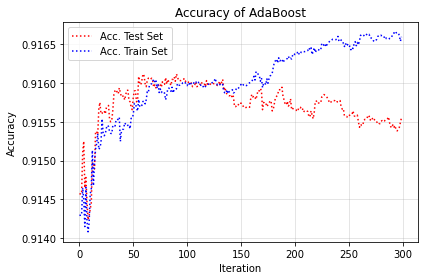

<Figure size 432x288 with 0 Axes>

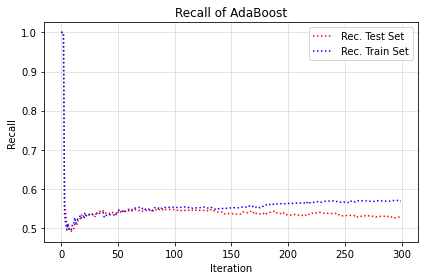

GradientBoostingClassifier(n_estimators=300) GradientBoost


<Figure size 432x288 with 0 Axes>

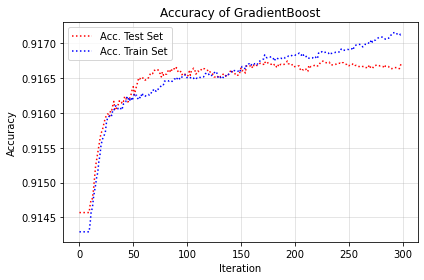

<Figure size 432x288 with 0 Axes>

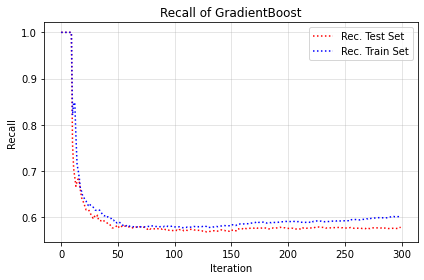

HistGradientBoostingClassifier(early_stopping=False, max_iter=300) HistGradientBoost


<Figure size 432x288 with 0 Axes>

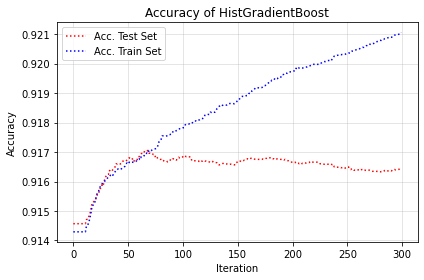

<Figure size 432x288 with 0 Axes>

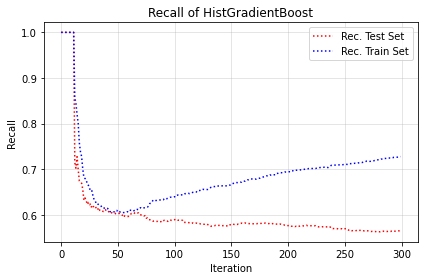

<catboost.core.CatBoostClassifier object at 0x7f1125be3730> CatBoost


<Figure size 432x288 with 0 Axes>

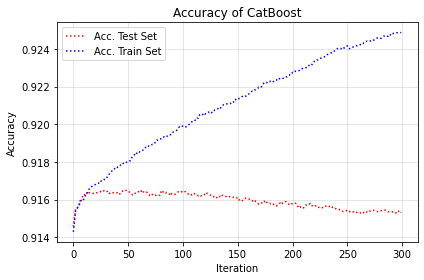

<Figure size 432x288 with 0 Axes>

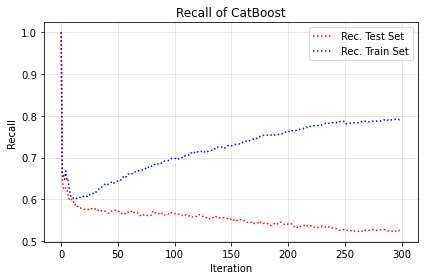

<Figure size 432x288 with 0 Axes>

In [56]:
classifier = [AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=300), 
             GradientBoostingClassifier(n_estimators=300),
             HistGradientBoostingClassifier(max_iter=300, early_stopping=False),
             CatBoostClassifier(n_estimators=300, verbose=0)]
names = ['AdaBoost', 'GradientBoost', 'HistGradientBoost', 'CatBoost']
for booster, name in zip(classifier, names):
    print(booster, name)
    boosting_estimators(booster, name)

In [14]:
def xgb_test(max_est):
    acc_test=[]
    acc_train=[]
    x=[]
    rec_test=[]
    rec_train=[]
    for i in range(0, int(max_est/10)):
        model = xgb.XGBClassifier(n_estimators=(i*10)+1, eval_metric='logloss', use_label_encoder=False)
        model.fit(train, target_train)
        y_prediction = model.predict(test)#
        y_prediction_train = model.predict(train)
        y_prediction_proba = model.predict_proba(test)
        acc_test.append(accuracy_score( target_test, y_prediction))
        acc_train.append(accuracy_score(target_train, y_prediction_train))
        rec_test.append(recall_score(target_test, y_prediction))
        rec_train.append(recall_score(target_train, y_prediction_train))
        x.append(i*10 + 1)
        
    plot_boosting_estimator(acc_test, acc_train, rec_test, rec_train, 'eXtremeGradientBoost')

/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/s

/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/robin/.local/anaconda3/envs/python3-env/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


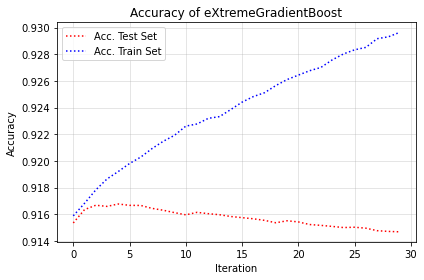

<Figure size 432x288 with 0 Axes>

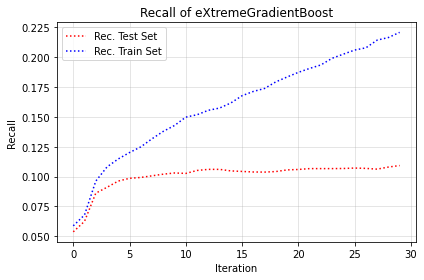

<Figure size 432x288 with 0 Axes>

In [15]:
xgb_test(300)

In [ ]:

params=[]
classifier = [DecisionTreeClassifier(max_depth=10, criterion='entropy', random_state=137),
              DecisionTreeClassifier(max_depth=10, criterion='gini', random_state=137),
              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=120, random_state=137), 
              GradientBoostingClassifier(n_estimators=150, random_state=137),
              HistGradientBoostingClassifier(max_iter=300, early_stopping=True, random_state=137),
              CatBoostClassifier(n_estimators=50, verbose=0, random_state=137),
              xgb.XGBClassifier(n_estimators=100, eval_metric='logloss', use_label_encoder=False, random_state=137)]
names = ['DTC_entropy', 'DTC_gini', 'AdaBoost', 'GradientBoost', 'HistGradientBoost', 'CatBoost', 'XGBoost']
for algo, name in zip(classifier, names):
    print(name)
    params.append(cross_val(algo))
    

DTC_entropy
Area under RoC curve: 0.8130 ± 0.0035
Accuracy:             0.9134 ± 0.0006
Recall:               0.0768 ± 0.0144
DTC_gini
Area under RoC curve: 0.8132 ± 0.0032
Accuracy:             0.9123 ± 0.0006
Recall:               0.0868 ± 0.0148
AdaBoost


In [42]:
rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=137)
print('Cross Validation Random Forest Classifier')
cross_val(rf)

Cross Validation Random Forest Classifier
Area under RoC curve: 0.8344 ± 0.0015
Accuracy:             0.9153 ± 0.0005
Recall:               0.0612 ± 0.0051


In [1]:
bg = BaggingClassifier(n_estimators=300, random_state=137)
print('Cross Validation Bagging Classifier ')
cross_val(bg)

NameError: name 'BaggingClassifier' is not defined

In [17]:
from imblearn.over_sampling import ADASYN, RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline

In [31]:
over_sampler = [RandomOverSampler(), SMOTE(), ADASYN()]
algos = [DecisionTreeClassifier(max_depth=12, criterion='entropy'),
         HistGradientBoostingClassifier(max_iter=300, early_stopping=True), 
         CatBoostClassifier(n_estimators=300, verbose=0)]

In [32]:
for sampler in over_sampler:
    for algorithm in algos:
        model = make_pipeline(sampler, algo)
        print(model)
        cross_val(model)

Pipeline(steps=[('randomoversampler', RandomOverSampler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7fbae81eae80>)])
Area under RoC curve: 0.8261 ± 0.0014
Accuracy:             0.7601 ± 0.0017
Recall:               0.7362 ± 0.0081
Pipeline(steps=[('randomoversampler', RandomOverSampler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7fbae81eae80>)])


KeyboardInterrupt: 

In [70]:
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, TomekLinks
model = make_pipeline(RandomUnderSampler(), DecisionTreeClassifier(max_depth=6))

In [42]:
cross_val(model)

Area under RoC curve: 0.8421 ± 0.0019
Accuracy:             0.7314 ± 0.0008
Recall:               0.8087 ± 0.0035


In [43]:
from imblearn.ensemble import RUSBoostClassifier

In [80]:
rus = RUSBoostClassifier(n_estimators=100)

In [81]:
a, b = training(rus)

In [72]:
model.fit(train, target_train)

Pipeline(steps=[('randomundersampler', RandomUnderSampler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=6))])

In [79]:
pd.Series(rus.feature_importances_, index=data.columns)

BMI                 0.326667
Smoking             0.016667
AlcoholDrinking     0.003333
Stroke              0.046667
PhysicalHealth      0.063333
MentalHealth        0.043333
DiffWalking         0.026667
Sex                 0.010000
AgeCategory         0.116667
Race                0.023333
Diabetic            0.010000
PhysicalActivity    0.000000
GenHealth           0.063333
SleepTime           0.146667
Asthma              0.020000
KidneyDisease       0.056667
SkinCancer          0.026667
dtype: float64

In [78]:
res = "\n".join("{} {}".format(x, y) for x, y in zip(data.columns, model.steps[1][1].feature_importances_))
print(res)

BMI 0.005530833612307523
Smoking 0.0032419683054256535
AlcoholDrinking 0.0005497328766124294
Stroke 0.05521141121267712
PhysicalHealth 0.0015283850816704568
MentalHealth 0.000704138662971497
DiffWalking 0.0038414795380513314
Sex 0.060364797294162394
AgeCategory 0.5586850200057463
Race 0.0019783487696937024
Diabetic 0.01305641406623163
PhysicalActivity 0.001064839875788024
GenHealth 0.290741285921143
SleepTime 0.0019883982985608763
Asthma 0.001512946478957966
KidneyDisease 0.0
SkinCancer 0.0


(array([90412.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 37506.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

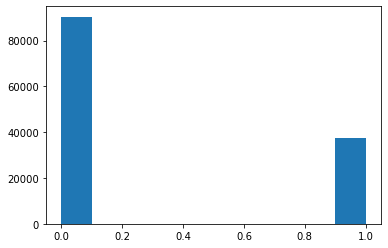

In [85]:
plt.hist(a)

(array([116990.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  10928.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

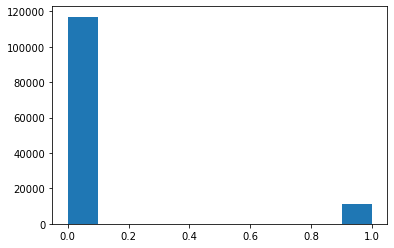

In [86]:
plt.hist(target_test)